In [80]:
import uuid
from pathlib import Path

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

import skimage

import pandas as pd
import matplotlib.pyplot as plt

In [78]:
DATA = Path("C:/Users/hp/Desktop/datasets/test")
image_dir = DATA / "images"
mask_dir = DATA / "masks"
data_table = DATA / "metadata" / "dataset.csv"

CROPPED_DATA = DATA / "cropped"
cropped_image_dir = CROPPED_DATA / "images"
cropped_mask_dir = CROPPED_DATA / "masks"
cropped_data_table = CROPPED_DATA / "metadata" / "dataset.csv"

In [71]:
def get_pad_amount(x, w):
    return w-(x%w) 

def split_pad_amount(pad_amount):
    if pad_amount % 2 == 0:
        after = pad_amount // 2
        before = after
    else:
        after = (pad_amount // 2) + 1
        before = after - 1
    assert before+after==pad_amount 
    return (before, after)

def get_padded_image(array, window_side):

    height = array.shape[0]
    width = array.shape[1]

    height_pad = get_pad_amount(height, window_side)
    width_pad = get_pad_amount(width, window_side)

    return np.pad(
        array = array,
        pad_width = (split_pad_amount(height_pad),
                     split_pad_amount(width_pad),
                     (0, 0),)
    )

def get_cropped_images(array, window_side):
    assert array.ndim == 3 
    crops = skimage.util.view_as_windows(
        arr_in = array,
        window_shape = (window_side, window_side, array.shape[2]),
        step =  (window_side, window_side, array.shape[2])
    ).squeeze()
    #crops = sliding_window_view(x = array, 

            #window_shape = (window_side, window_side),
            #axis = (0, 1))
    #crops = crops[:, ::window_side, ::window_side, :, :] 
    #crops = crops.reshape((crops.shape[0], 
                           #crops.shape[1] * crops.shape[2], 
                           #window_side, 
                           #window_side))
    #crops = crops.transpose(1, 0, 2, 3)
    return crops

In [56]:
#scene_name = "austin1.tif"
scene_name = "top_mosaic_09cm_area1.tif"
img = skimage.io.imread(image_dir / scene_name)
mask = skimage.io.imread(mask_dir / scene_name)

In [57]:
CROP = 512 
padded_img = get_padded_image(img, CROP)
padded_mask = get_padded_image(mask, CROP)

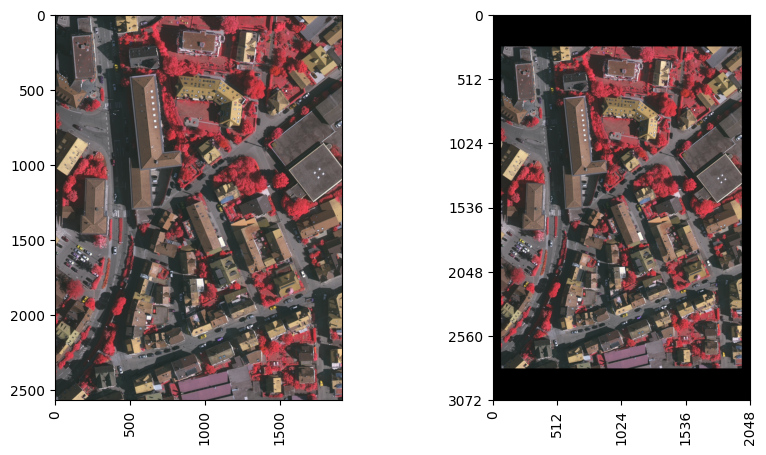

In [58]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.yticks(np.arange(0, img.shape[0]+1, 500));
plt.xticks(np.arange(0, img.shape[1]+1, 500), rotation = 90);

plt.subplot(1, 2, 2)
plt.imshow(padded_img)
plt.yticks(np.arange(0, padded_img.shape[0]+1, CROP));
plt.xticks(np.arange(0, padded_img.shape[1]+1, CROP), rotation = 90);


In [72]:
img_crops = get_cropped_images(padded_img, CROP)
cropped_images = img_crops.reshape(-1, CROP, CROP, padded_img.shape[2])
print(img_crops.shape)

(6, 4, 512, 512, 3)


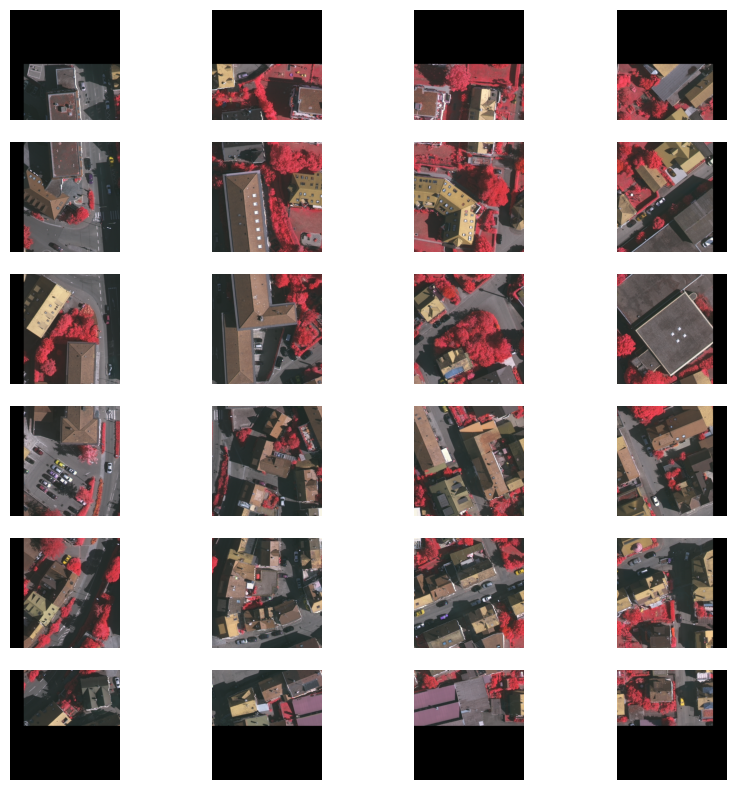

In [79]:
fig = plt.figure(figsize = (10, 10))
for idx, crop in enumerate(cropped_images):
    skimage.io.imsave((cropped_image_dir / f"{idx}.jpg"), crop)

    ax = plt.subplot(img_crops.shape[0], img_crops.shape[1], idx+1)
    ax.imshow(crop)
    ax.set_axis_off()


In [82]:
class DatasetETL():
    def __init__(self, root:Path):
        self.root = root 

        self.image_dir = root / "images"
        self.masks_dir = root / "masks"

        downloaded_dataset_path = self.root / "metadata" / "downloaded-dataset.csv"
        if downloaded_dataset_path.is_file():
            self.downloaded_dataset = pd.read_csv(downloaded_dataset_path)
        else: 
            self.downloaded_dataset = None

    def crop():
        pass
    def pad():
        pass
    def Transform():
        pass

    def _read_image(self, path):
        return skimage.io.imread(path) 

    def _read_mask(self, path):
        return skimage.io.imread(path) 

    def _get_pad_amount(self, dimension: int, window: int):
        """Calculate to no of pixels to add to before and after dimension"""
        total_padding = window - (dimension % window)

        if total_padding % 2 == 0:
            after = total_padding // 2
            before = after
        else:
            after = (total_padding // 2) + 1
            before = after - 1
        assert before+after == total_padding 
        return (before, after)
    
    def _pad_3d_array(self, array: np.ndarray, window: int):
        """
        Pad image array s.t. divisible by window\n
        array.shape : (Height, Width, Channels)
        window : side length of square cropping window
        """

        assert array.ndim == 3
        padded_array = np.pad(
            array = array,
            pad_width = (self._get_pad_amount(array.shape[0]),
                         self._get_pad_amount(array.shape[1]),
                         (0, 0))
        ) 
        return padded_array
    
    def _get_cropped_view(self, array: np.ndarray, window:int):
        """
        Crop image array s.t. divisible by window\n
        array.shape : (Height, Width, Channels)
        window : side length of square cropping window
        """

        assert array.ndim == 3
        cropped_view = skimage.util.view_as_windows(
            arr_in = array,
            window_shape = (window, window, array.shape[2]),
            step =  (window, window, array.shape[2])).squeeze()
            
        cropped_view = cropped_view.reshape(-1, window, window, array.shape[2])

        return cropped_view
    
    def _save_as_jpeg_100(array: np.ndarray, out_path: Path) -> None:
        skimage.io.imsave(out_path, array, **{"quality": 100})